![](https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png)

# Visualización del comportamiento de validación cruzada en scikit-learn

## Aprendizaje Automático Aplicado

### Maestría en Ciencia de Datos

#### **Julio Waissman**, 2026

[**Abrir en google Colab**](https://colab.research.google.com/github/mcd-unison/aaa-curso/blob/main/ejemplos/plot_cv_indices.ipynb)

**Tomado de [este tutorial](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html)**. Solamente lo pongo en español.

Elegir el objeto de validación cruzada adecuado es crucial para ajustar correctamente un modelo. Existen muchas maneras de dividir los datos en conjuntos de entrenamiento y de prueba para evitar el sobreajuste del modelo, estandarizar el número de grupos en los conjuntos de prueba, etc.

Este ejemplo visualiza el comportamiento de varios objetos comunes de scikit-learn para su comparación.

In [1]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

from sklearn.model_selection import (
    GroupKFold,
    GroupShuffleSplit,
    KFold,
    ShuffleSplit,
    StratifiedGroupKFold,
    StratifiedKFold,
    StratifiedShuffleSplit,
    TimeSeriesSplit,
)

rng = np.random.RandomState(1338)

# Los colores de la paleta de matplotlib
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

# Vamos a visualizar n_splits carpetas de validación cruzada
n_splits = 4

## Visualizando los datos

Primero, debemos comprender la estructura de nuestros datos. Consta de 100 puntos de entrada generados aleatoriamente, 3 clases distribuidas de forma desigual entre los puntos de datos y 10 "grupos" distribuidos de forma uniforme entre los puntos de datos.

Como veremos, algunos objetos de validación cruzada realizan acciones específicas con datos etiquetados, otros se comportan de forma diferente con datos agrupados y otros no utilizan esta información.

Para comenzar, visualizaremos nuestros datos.

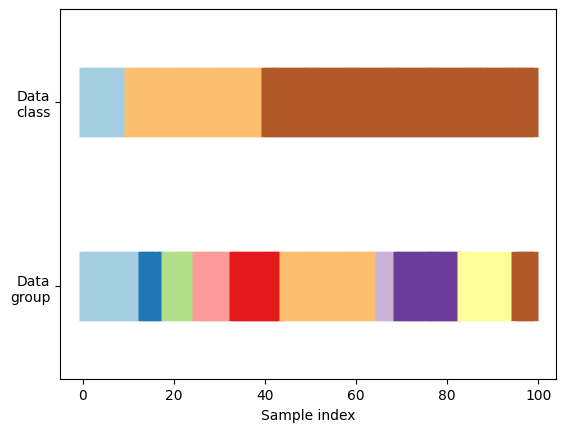

In [2]:
# Generate the class/group data
n_points = 100
X = rng.randn(100, 10)

percentiles_classes = [0.1, 0.3, 0.6]
y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

# Generate uneven groups
group_prior = rng.dirichlet([2] * 10)
groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))


def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


visualize_groups(y, groups, "no groups")

## Definir una función para visualizar el comportamiento de validación cruzada

Definiremos una función que nos permita visualizar el comportamiento de cada objeto de validación cruzada. Realizaremos cuatro divisiones de los datos. En cada división, visualizaremos los índices elegidos para el conjunto de entrenamiento (en azul) y el conjunto de prueba (en rojo).


In [3]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    use_groups = "Group" in type(cv).__name__
    groups = group if use_groups else None
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=groups)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

Veamos cómo se ve el objeto de validación cruzada de la clase `sklearn.model_selection.KFold`:



<Axes: title={'center': 'KFold'}, xlabel='Sample index', ylabel='CV iteration'>

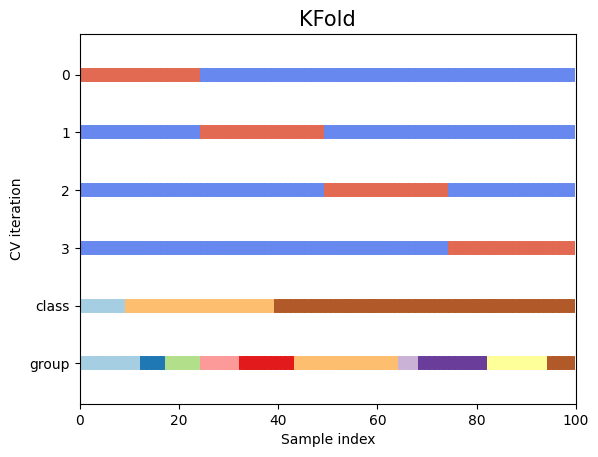

In [4]:
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, X, y, groups, ax, n_splits)

Como se puede ver, por defecto, el generador de validación cruzada KFold no considera ni la clase ni el grupo de datos. Podemos cambiar esto usando:

- ``StratifiedKFold`` para conservar el porcentaje de muestras de cada clase.
- ``GroupKFold`` para garantizar que el mismo grupo no aparezca en dos folders diferentes.
- ``StratifiedGroupKFold`` para mantener la restricción de ``GroupKFold`` al intentar devolver folders estratificados.


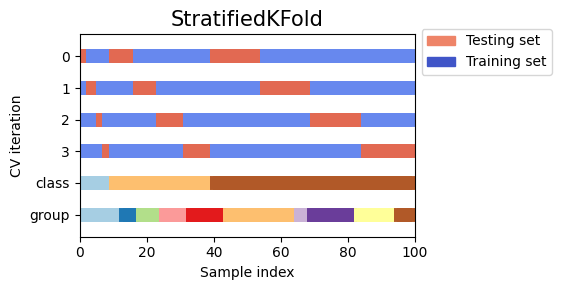

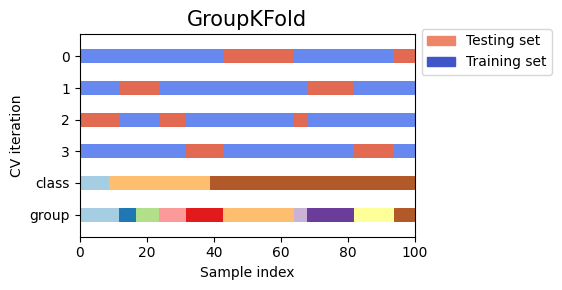

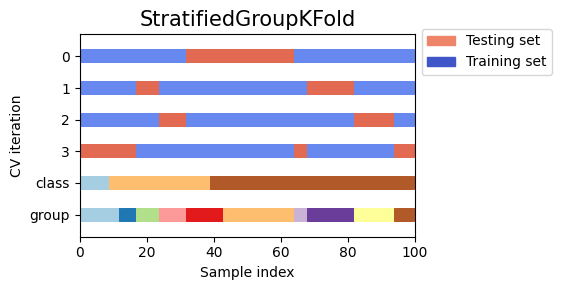

In [5]:
cvs = [StratifiedKFold, GroupKFold, StratifiedGroupKFold]

for cv in cvs:
    fig, ax = plt.subplots(figsize=(6, 3))
    plot_cv_indices(cv(n_splits), X, y, groups, ax, n_splits)
    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)

A continuación, visualizaremos este comportamiento para varios iteradores CV.

## Visualizar índices de validación cruzada para muchos objetos CV

Comparemos visualmente el comportamiento de la validación cruzada de varios objetos de validación cruzada de scikit-learn. A continuación, recorreremos varios objetos comunes de validación cruzada, visualizando el comportamiento de cada uno.

Observa cómo algunos utilizan la información de grupo/clase, mientras que otros no.


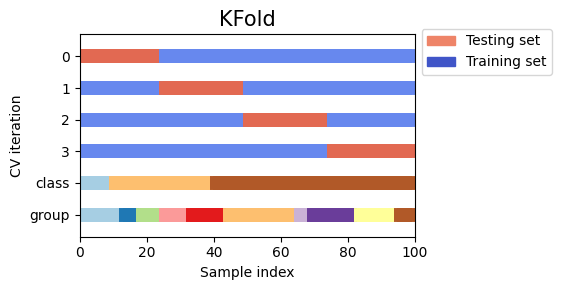

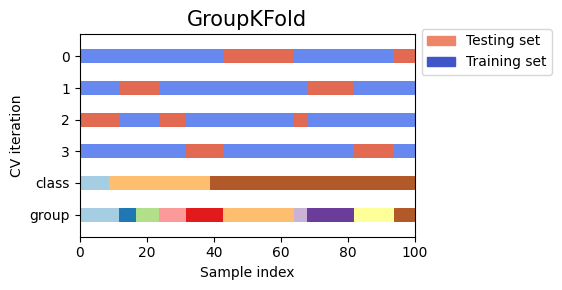

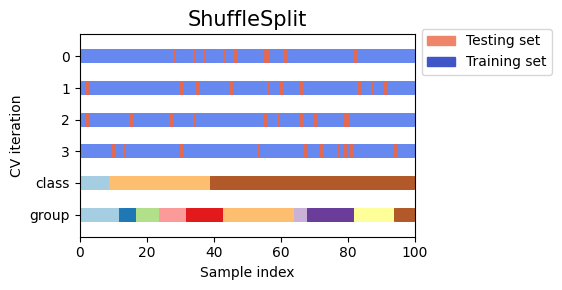

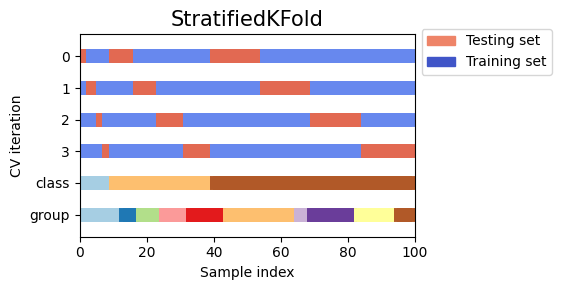

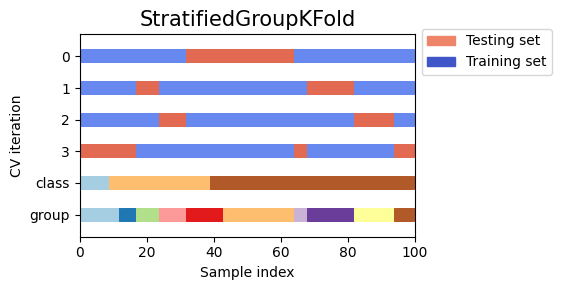

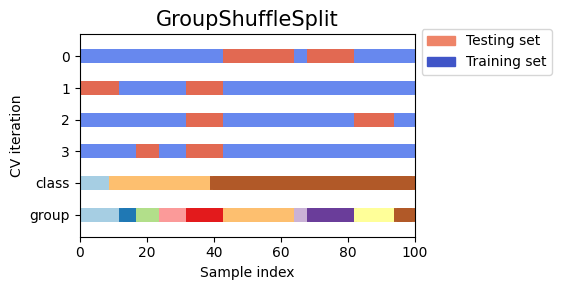

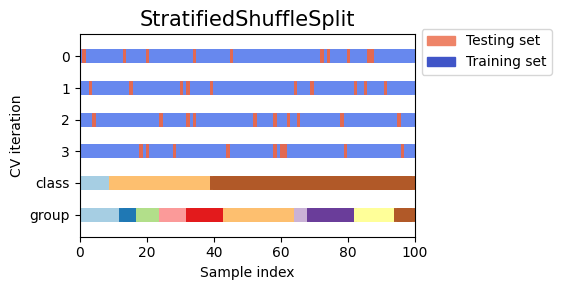

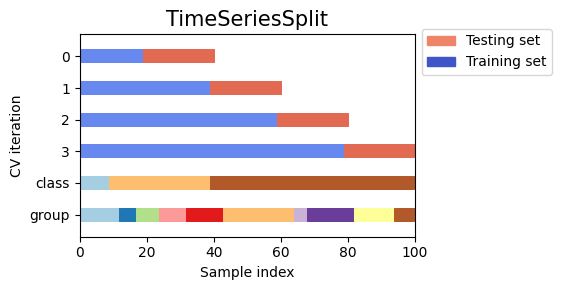

In [6]:
cvs = [
    KFold,
    GroupKFold,
    ShuffleSplit,
    StratifiedKFold,
    StratifiedGroupKFold,
    GroupShuffleSplit,
    StratifiedShuffleSplit,
    TimeSeriesSplit,
]


for cv in cvs:
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(6, 3))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
plt.show()